딥러닝 기반 (AutoEncoder) 신용카드 사기 거래 탐지 모델

In [3]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [4]:
d = pd.read_csv('creditcard.csv')

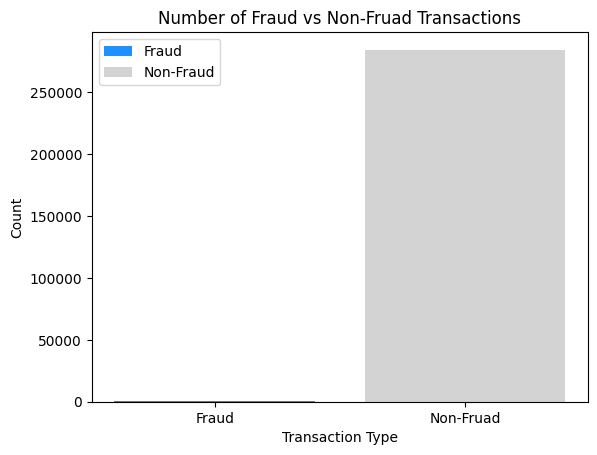

In [5]:
num_nonfraud = np.sum(d['Class'] == 0)
num_fraud = np.sum(d['Class'] == 1)

fraud_label = 'Fraud'
nonfraud_label = 'Non-Fruad'

fraud_count = [num_fraud]
nonfraud_count = [num_nonfraud]

plt.bar(fraud_label, fraud_count, color='dodgerblue', label='Fraud')
plt.bar(nonfraud_label, nonfraud_count, color='lightgrey', label='Non-Fraud')

plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.title('Number of Fraud vs Non-Fruad Transactions')
plt.legend()
plt.show()

In [6]:
data = d.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data[['Amount']])
X = data.drop(['Class'], axis=1)
Y = data.Class

오토인코더 모델 설정 / 인코더 및 디코더 레이어 정의

In [7]:
#오토인코더 파라미터 설정
input_dim = X.shape[1]
encoding_dim = 128
num_epoch = 30
batch_size = 256

input_layer = Input(shape=(input_dim, )) #입력 레이어 정의

# 인코더 레이어 정의
encoder = Dense(encoding_dim,
                activation="tanh",
                activity_regularizer=regularizers.l1(10e-5)
                )(input_layer)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU(alpha=0.2)(encoder)

encoder = Dense(int(encoding_dim/2),
                activation="relu",
                )(encoder)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU(alpha=0.1)(encoder)

encoder = Dense(int(encoding_dim/4),
                activation="relu"
                )(encoder)
encoder = BatchNormalization()(encoder)

# 디코더 레이어 정의
decoder = LeakyReLU(alpha=0.1)(encoder)
decoder = Dense(int(encoding_dim/4),
                activation='tanh'
                )(encoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU(alpha=0.1)(decoder)

decoder = Dense(int(encoding_dim/2),
                activation='tanh',
                )(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU(alpha=0.1)(decoder)

decoder = Dense(input_dim,
                activation='relu',
                )(decoder)

autoencoder = Model(inputs=input_layer,
                    outputs=decoder
                    )

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['mae', 'mse']
                    )

In [9]:
checkpointer = ModelCheckpoint(filepath="autoencoder_model.keras",
                               verbose=0,
                               save_best_only=True
                               )

autoencoder 모델 훈련

In [10]:
history = autoencoder.fit(X,
                          X,
                          epochs=num_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          verbose=1,
                          callbacks=[checkpointer]
                          ).history

Epoch 1/30
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.2804 - mae: 0.5442 - mse: 0.8295
Epoch 2/30
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.7308 - mae: 0.4590 - mse: 0.6751
Epoch 3/30
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7218 - mae: 0.4421 - mse: 0.6685
Epoch 4/30
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6984 - mae: 0.4320 - mse: 0.6563
Epoch 5/30
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6857 - mae: 0.4253 - mse: 0.6486
Epoch 6/30
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7027 - mae: 0.4236 - mse: 0.6628
Epoch 7/30
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6906 - mae: 0.4194 - mse: 0.6500
Epoch 8/30
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6719 - mae: 0.4150 - mse: 0.6426
Epoch 9/30
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6718 - mae: 0.4129 - mse: 0.6415
Epoch 10/30
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6558 - mae: 0.4096 - mse: 0.6260
Epoch 11/30
1113/1113 ━━━━━━━

MSE / MAE, MSE 변화 시각화

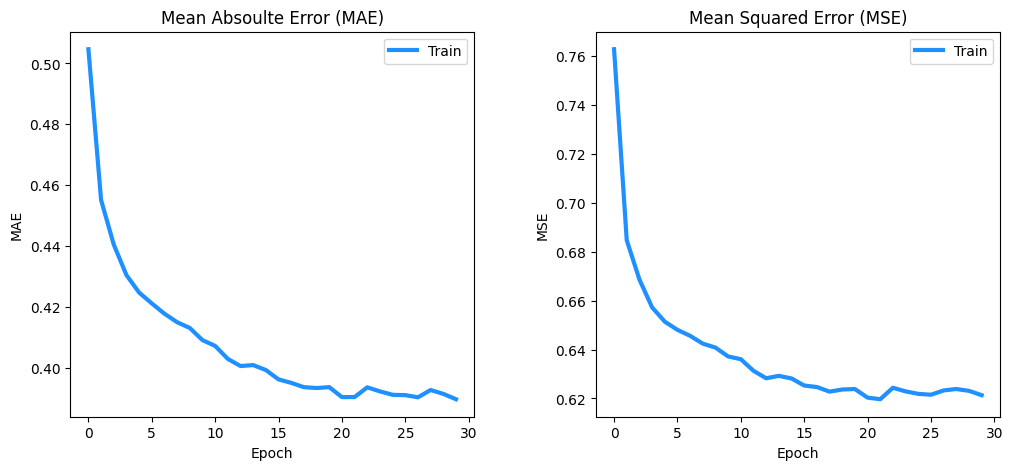

In [11]:
# 평균절대오차 그래프
plt.subplot(121)
plt.plot(history['mae'], c='dodgerblue', lw=3)
plt.title('Mean Absoulte Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')

# 평균제곱오차 그래프
plt.subplot(122)
plt.plot(history['mse'], c='dodgerblue', lw=3)
plt.title('Mean Squared Error (MSE)')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')

plt.subplots_adjust(wspace=0.3)
plt.gcf().set_size_inches(12, 5)

plt.show()

테스트 코드 재구성

In [13]:
# 훈련된 오토인코더를 사용하여 테스트셋을 재구성
pred_X = autoencoder.predict(X)

# 재구성 오차 계산
mse_X = np.mean(np.power(X - pred_X, 2), axis=1)
mae_X = np.mean(np.abs(X - pred_X), axis=1)

# 재구성 오차 추가
data['mse_X'] = mse_X
data['mae_X'] = mae_X

# TopN 정확도 평가
n = 1000
df = data.sort_values(by='mae_X', ascending=False)
top_n_df = df.head(n)
accuracy = top_n_df[top_n_df['Class'] == 1].shape[0] / n
print('Top-{} 정확도: {}'.format(n, accuracy))

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 5s 578us/step
Top-1000 정확도: 0.218


2671/2671 ━━━━━━━━━━━━━━━━━━━━ 2s 620us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


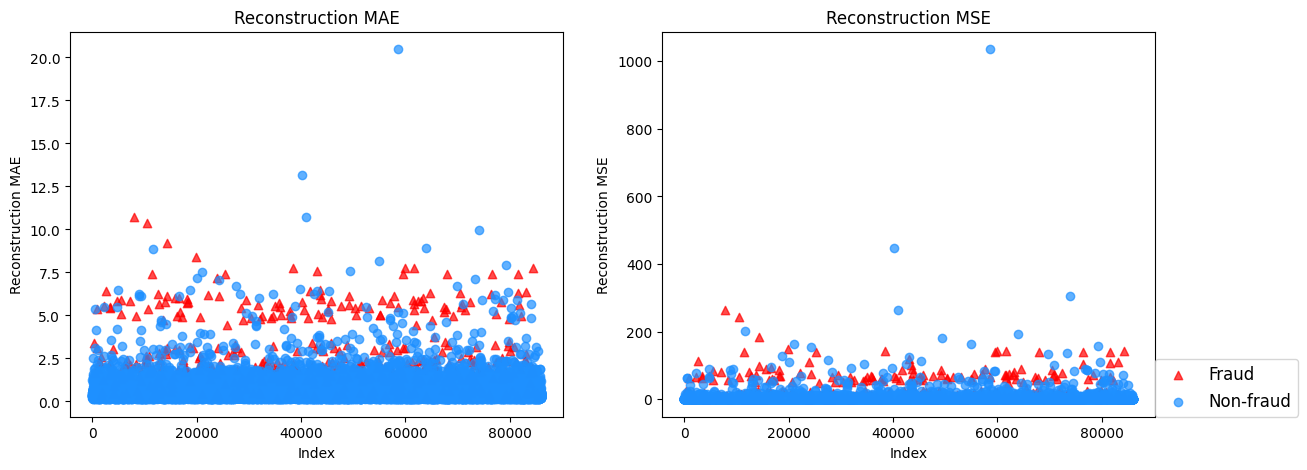

In [14]:
# 'Class'가 0인 행, 즉 부정 행위가 아닌 행 추출, 7:3 훈련셋과 데이터셋 분리
mask = (data['Class'] == 0)
X_train, X_test = train_test_split(X, test_size=0.3, random_state=520)

# 'Class'가 1인 행을 테스트셋 일부로 설정
X_fraud = X[~mask]

# 훈련된 autoencoder를 이용해 테스트셋 재구성
pred_test = autoencoder.predict(X_test)
pred_fraud = autoencoder.predict(X_fraud)

# 재구성 오차인 평균제곱오차 / 평균절대오차 계산
mse_test = np.mean(np.power(X_test - pred_test, 2), axis=1)
mse_fraud = np.mean(np.power(X_fraud - pred_fraud, 2), axis=1)
mae_test = np.mean(np.abs(X_test - pred_test), axis=1)
mae_fraud = np.mean(np.abs(X_fraud - pred_fraud), axis=1)
mse_df = pd.DataFrame()
mse_df['Class'] = [0] * len(mse_test) + [1] * len(mse_fraud)
mse_df['MSE'] = np.hstack([mse_test, mse_fraud])
mse_df['MAE'] = np.hstack([mae_test, mae_fraud])
mse_df = mse_df.sample(frac=1).reset_index(drop=True)

# 테스트셋에서 정상 샘플과 부정 행위 샘플의 재구성 오차 그림으로 표현
markers = ['o', '^']
markers = ['o', '^']
colors = ['dodgerblue', 'red']
labels = ['Non-fraud', 'Fraud']

plt.figure(figsize=(14, 5))
plt.subplot(121)
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp.index,
                temp['MAE'],
                alpha=0.7,
                marker=markers[flag],
                c=colors[flag],
                label=labels[flag])
plt.title('Reconstruction MAE')
plt.ylabel('Reconstruction MAE')
plt.xlabel('Index')

plt.subplot(122)
for flag in [1,0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp.index,
                temp['MSE'],
                alpha=0.7,
                marker=markers[flag],
                c=colors[flag],
                label=labels[flag])
plt.legend(loc=[1, 0], fontsize=12)
plt.title('Reconstruction MSE')
plt.ylabel('Reconstruction MSE')
plt.xlabel('Index')
plt.show()